# 와인 데이터를 이용한 딥러닝 다중 클래스 분류 모델

이 노트북에서는 sklearn의 와인 데이터셋을 사용하여 딥러닝 모델을 구축하고 3가지 와인 종류를 분류합니다.

## 목차
1. 라이브러리 임포트
2. 데이터 로딩 및 탐색
3. 데이터 전처리
4. 딥러닝 모델 구성
5. 모델 훈련
6. 모델 평가
7. 결과 시각화
8. 결론 및 요약

## 프로젝트 개요
- **문제 유형**: 다중 클래스 분류 (3개 클래스)
- **데이터셋**: sklearn 와인 데이터셋
- **목표**: 와인의 화학적 특성을 바탕으로 와인 종류 분류


## 1. 라이브러리 임포트

필요한 라이브러리들을 임포트합니다.


In [5]:
# 데이터 처리 및 머신러닝 라이브러리
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

# 딥러닝 라이브러리
import tensorflow as tf
import keras
from keras import models, layers
from keras.utils import to_categorical

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

# 기타 유틸리티
import pickle

# 한글 폰트 설정 (한글 글꼴 오류 해결)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# macOS의 경우: plt.rcParams['font.family'] = 'AppleGothic'
# Linux의 경우: plt.rcParams['font.family'] = 'DejaVu Sans'

print("라이브러리 임포트 완료!")
print(f"TensorFlow 버전: {tf.__version__}")
print(f"Keras 버전: {keras.__version__}")


라이브러리 임포트 완료!
TensorFlow 버전: 2.15.1
Keras 버전: 2.15.0


## 2. 데이터 로딩 및 탐색

와인 데이터셋을 로딩하고 기본적인 정보를 확인합니다.


In [6]:
# 와인 데이터셋 로딩
wine = load_wine()

# 특성 데이터를 DataFrame으로 변환
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = wine.target

print("=== 데이터셋 기본 정보 ===")
print(f"데이터 shape: {X.shape}")
print(f"특성 개수: {len(wine.feature_names)}")
print(f"클래스 개수: {len(wine.target_names)}")
print(f"클래스 이름: {wine.target_names}")

print("\n=== 타겟 값 분포 ===")
for i, name in enumerate(wine.target_names):
    print(f"클래스 {i} ({name}): {sum(y == i)}개")

print("\n=== 결측값 확인 ===")
print(f"결측값 개수: {X.isna().sum().sum()}")

print("\n=== 첫 5개 샘플 정보 ===")
print(X.head())


=== 데이터셋 기본 정보 ===
데이터 shape: (178, 13)
특성 개수: 13
클래스 개수: 3
클래스 이름: ['class_0' 'class_1' 'class_2']

=== 타겟 값 분포 ===
클래스 0 (class_0): 59개
클래스 1 (class_1): 71개
클래스 2 (class_2): 48개

=== 결측값 확인 ===
결측값 개수: 0

=== 첫 5개 샘플 정보 ===
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.0

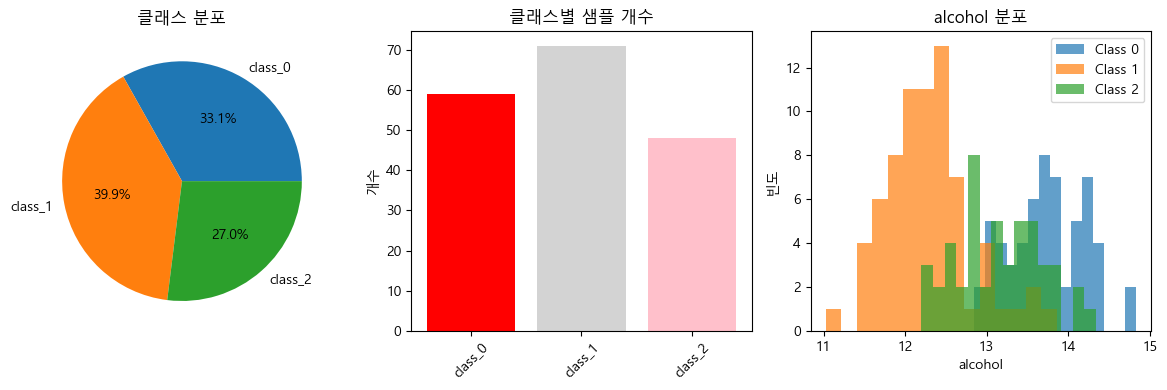

In [8]:
# 클래스 분포 시각화
plt.figure(figsize=(12, 4))

# 파이 차트
plt.subplot(1, 3, 1)
class_counts = [sum(y == i) for i in range(len(wine.target_names))]
plt.pie(class_counts, labels=wine.target_names, autopct='%1.1f%%')
plt.title('클래스 분포')

# 막대 그래프 - 수정된 부분
plt.subplot(1, 3, 2)
plt.bar(wine.target_names, class_counts, color=['red', 'lightgray', 'pink'])
plt.title('클래스별 샘플 개수')
plt.ylabel('개수')
plt.xticks(rotation=45)

# 특성들의 분포 (처음 5개 특성)
plt.subplot(1, 3, 3)
for i in range(len(wine.target_names)):
    subset = X[y == i]
    plt.hist(subset.iloc[:, 0], alpha=0.7, label=f'Class {i}', bins=15)
plt.title(f'{wine.feature_names[0]} 분포')
plt.xlabel(wine.feature_names[0])
plt.ylabel('빈도')
plt.legend()

plt.tight_layout()
plt.show()

## 3. 데이터 전처리

데이터를 훈련용과 테스트용으로 분할하고, 표준화 및 원핫 인코딩을 수행합니다.


In [9]:
# 데이터 분할 (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    random_state=123, 
    test_size=0.2,
    stratify=y  # 클래스 비율을 유지
)

print("=== 데이터 분할 결과 ===")
print(f"훈련 데이터 shape: {X_train.shape}")
print(f"테스트 데이터 shape: {X_test.shape}")

# 각 클래스별 분포 확인
print("\n=== 훈련 데이터 클래스 분포 ===")
for i in range(len(wine.target_names)):
    print(f"클래스 {i}: {sum(y_train == i)}개")

print("\n=== 테스트 데이터 클래스 분포 ===")
for i in range(len(wine.target_names)):
    print(f"클래스 {i}: {sum(y_test == i)}개")

# 표준화 (StandardScaler 적용)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # 주의: fit_transform이 아닌 transform 사용

print("\n=== 표준화 완료 ===")
print(f"표준화 전 훈련 데이터 평균: {X_train.mean().mean():.4f}")
print(f"표준화 후 훈련 데이터 평균: {X_train_scaled.mean():.4f}")
print(f"표준화 후 훈련 데이터 표준편차: {X_train_scaled.std():.4f}")

# 원핫 인코딩 (다중 클래스 분류를 위해)
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("\n=== 원핫 인코딩 완료 ===")
print(f"원본 타겟 shape: {y_train.shape}")
print(f"인코딩된 타겟 shape: {y_train_encoded.shape}")
print(f"원본 타겟 예시: {y_train[:5]}")
print(f"인코딩된 타겟 예시:")
print(y_train_encoded[:5])


=== 데이터 분할 결과 ===
훈련 데이터 shape: (142, 13)
테스트 데이터 shape: (36, 13)

=== 훈련 데이터 클래스 분포 ===
클래스 0: 47개
클래스 1: 57개
클래스 2: 38개

=== 테스트 데이터 클래스 분포 ===
클래스 0: 12개
클래스 1: 14개
클래스 2: 10개

=== 표준화 완료 ===
표준화 전 훈련 데이터 평균: 69.3759
표준화 후 훈련 데이터 평균: 0.0000
표준화 후 훈련 데이터 표준편차: 1.0000

=== 원핫 인코딩 완료 ===
원본 타겟 shape: (142,)
인코딩된 타겟 shape: (142, 3)
원본 타겟 예시: [0 0 2 1 0]
인코딩된 타겟 예시:
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


## 4. 딥러닝 모델 구성

다중 클래스 분류를 위한 순차적(Sequential) 딥러닝 모델을 구성합니다.


=== 모델 구조 ===
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 128)               1792      
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                8256      
                                                                 
 hidden_layer_3 (Dense)      (None, 32)                2080      
                                                                 
 hidden_layer_4 (Dense)      (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 3)                 99        
                                                                 
Total params: 13283 (51.89 KB)
Trainable params: 13283 (51.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


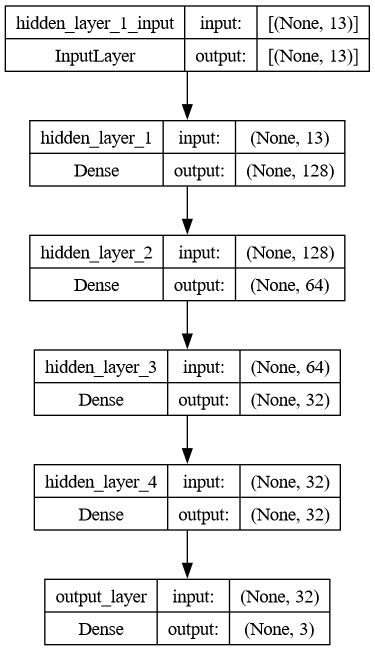

In [11]:
# 딥러닝 모델 구성
def create_model():
    """
    다중 클래스 분류를 위한 딥러닝 모델을 생성합니다.
    
    Returns:
        model: 컴파일된 Keras 모델
    """
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],), name='hidden_layer_1'),
        layers.Dense(64, activation='relu', name='hidden_layer_2'),
        layers.Dense(32, activation='relu', name='hidden_layer_3'),
        layers.Dense(32, activation='relu', name='hidden_layer_4'),
        layers.Dense(3, activation='softmax', name='output_layer')  # 3클래스 분류용 소프트맥스
    ])
    
    # 모델 컴파일
    model.compile(
        optimizer='rmsprop',              # RMSprop 옵티마이저
        loss='categorical_crossentropy',  # 다중 클래스 분류용 손실 함수
        metrics=['accuracy']             # 정확도 메트릭
    )
    
    return model

# 모델 생성
model = create_model()

# 모델 구조 확인
print("=== 모델 구조 ===")
model.summary()

# 모델 아키텍처 시각화
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


## 5. 모델 훈련

콜백을 설정하고 모델을 훈련시킵니다.


In [13]:
# 콜백 설정
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='와인분류_딥러닝.keras',
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        verbose=1,
        restore_best_weights=True
    )
]

print("=== 모델 훈련 시작 ===")
# 모델 훈련
history = model.fit(
    X_train_scaled, y_train_encoded,
    epochs=8,
    validation_data=(X_test_scaled, y_test_encoded),
    callbacks=callbacks,
    batch_size=100,
    verbose=1
)

print("\n=== 모델 훈련 완료 ===")

# 훈련 히스토리 저장
with open("와인분류_딥러닝.bin", "wb") as file:
    pickle.dump(history.history, file)
    
print("훈련 히스토리가 '와인분류_딥러닝.bin' 파일로 저장되었습니다.")


=== 모델 훈련 시작 ===
Epoch 1/8
1/2 [==============>...............] - ETA: 0s - loss: 0.3182 - accuracy: 0.9900
Epoch 1: val_loss improved from inf to 0.30978, saving model to 와인분류_딥러닝.keras
2/2 [==============================] - 0s 126ms/step - loss: 0.3266 - accuracy: 0.9859 - val_loss: 0.3098 - val_accuracy: 1.0000
Epoch 2/8
1/2 [==============>...............] - ETA: 0s - loss: 0.2588 - accuracy: 0.9900
Epoch 2: val_loss improved from 0.30978 to 0.26756, saving model to 와인분류_딥러닝.keras
2/2 [==============================] - 0s 72ms/step - loss: 0.2650 - accuracy: 0.9859 - val_loss: 0.2676 - val_accuracy: 0.9722
Epoch 3/8
1/2 [==============>...............] - ETA: 0s - loss: 0.2276 - accuracy: 0.9900
Epoch 3: val_loss improved from 0.26756 to 0.21747, saving model to 와인분류_딥러닝.keras
2/2 [==============================] - 0s 70ms/step - loss: 0.2144 - accuracy: 0.9930 - val_loss: 0.2175 - val_accuracy: 1.0000
Epoch 4/8
1/2 [==============>...............] - ETA: 0s - loss: 0.1808 - accura

## 6. 모델 평가

훈련된 모델의 성능을 평가합니다.


=== 모델 성능 평가 ===
훈련셋 손실값: 0.0639, 정확도: 0.9930
테스트셋 손실값: 0.1050, 정확도: 0.9722

=== 분류 리포트 ===
              precision    recall  f1-score   support

     class_0       0.92      1.00      0.96        12
     class_1       1.00      0.93      0.96        14
     class_2       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36


=== 혼동 행렬 ===
[[12  0  0]
 [ 1 13  0]
 [ 0  0 10]]


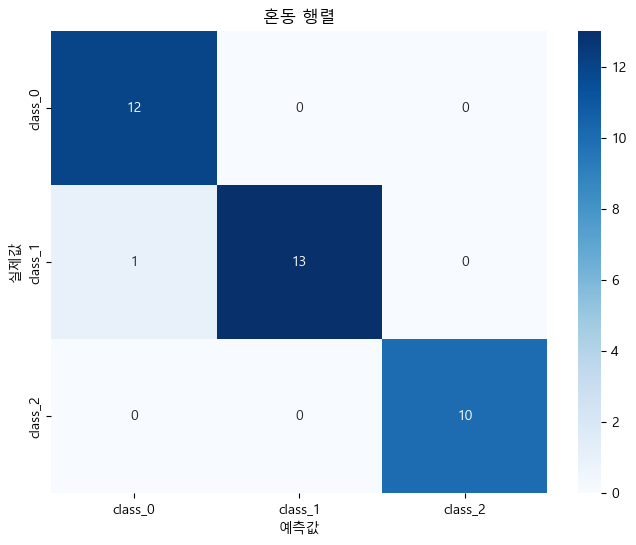

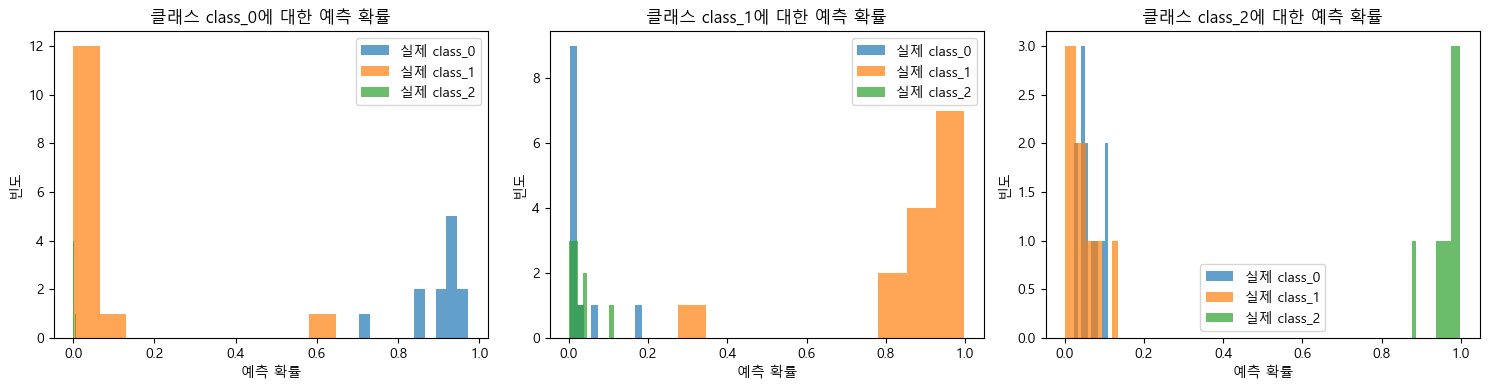

In [14]:
# 모델 성능 평가
print("=== 모델 성능 평가 ===")

# 훈련 데이터 평가
train_loss, train_acc = model.evaluate(X_train_scaled, y_train_encoded, verbose=0)
print(f"훈련셋 손실값: {train_loss:.4f}, 정확도: {train_acc:.4f}")

# 테스트 데이터 평가
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"테스트셋 손실값: {test_loss:.4f}, 정확도: {test_acc:.4f}")

# 예측 수행
y_pred_prob = model.predict(X_test_scaled, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

# 추가 평가 메트릭
from sklearn.metrics import classification_report, confusion_matrix

print("\n=== 분류 리포트 ===")
print(classification_report(y_test, y_pred, target_names=wine.target_names))

print("\n=== 혼동 행렬 ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=wine.target_names, 
            yticklabels=wine.target_names)
plt.title('혼동 행렬')
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.show()

# 각 클래스별 예측 확률 분포
plt.figure(figsize=(15, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    for j in range(3):
        mask = (y_test == j)
        plt.hist(y_pred_prob[mask, i], alpha=0.7, label=f'실제 {wine.target_names[j]}', bins=10)
    plt.title(f'클래스 {wine.target_names[i]}에 대한 예측 확률')
    plt.xlabel('예측 확률')
    plt.ylabel('빈도')
    plt.legend()
plt.tight_layout()
plt.show()


## 7. 결과 시각화

훈련 과정과 결과를 시각적으로 분석합니다.


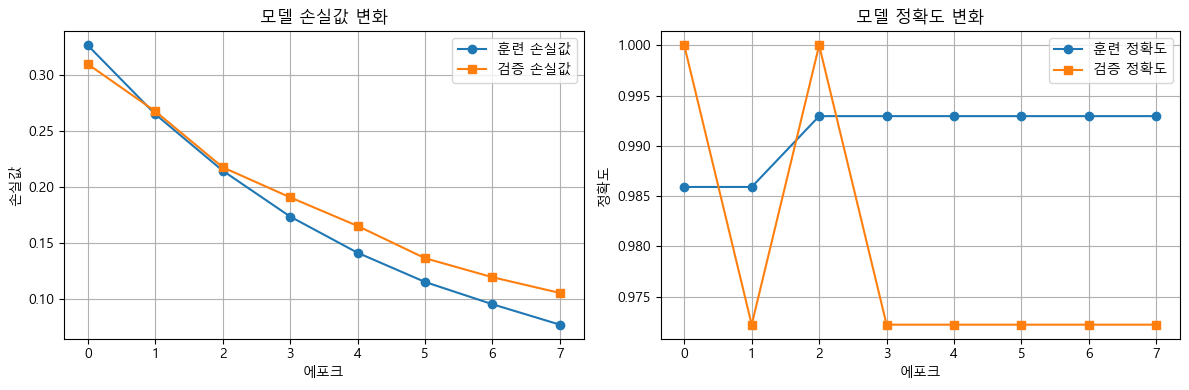

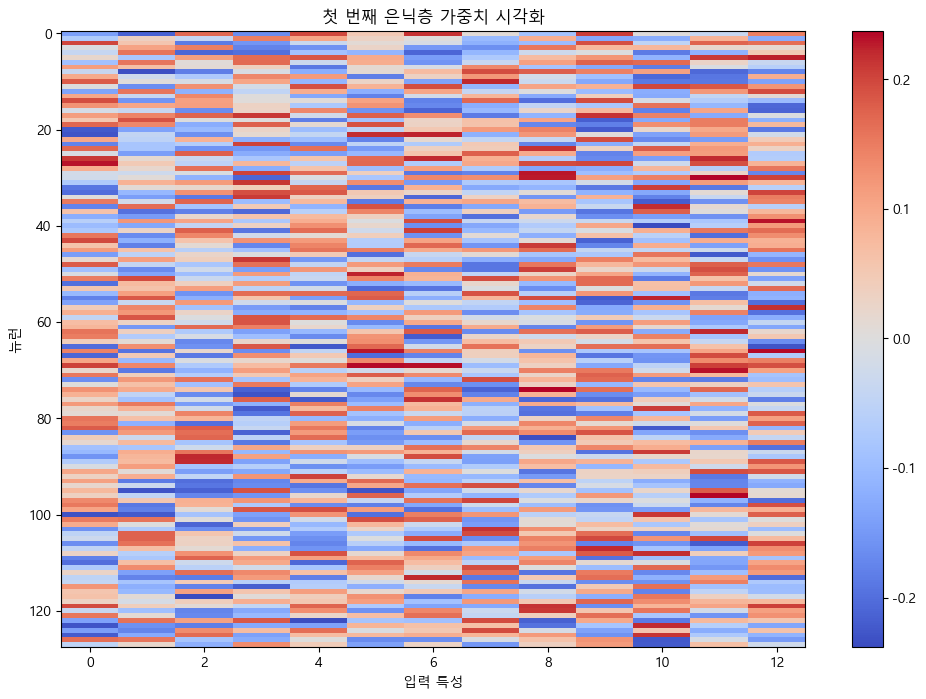

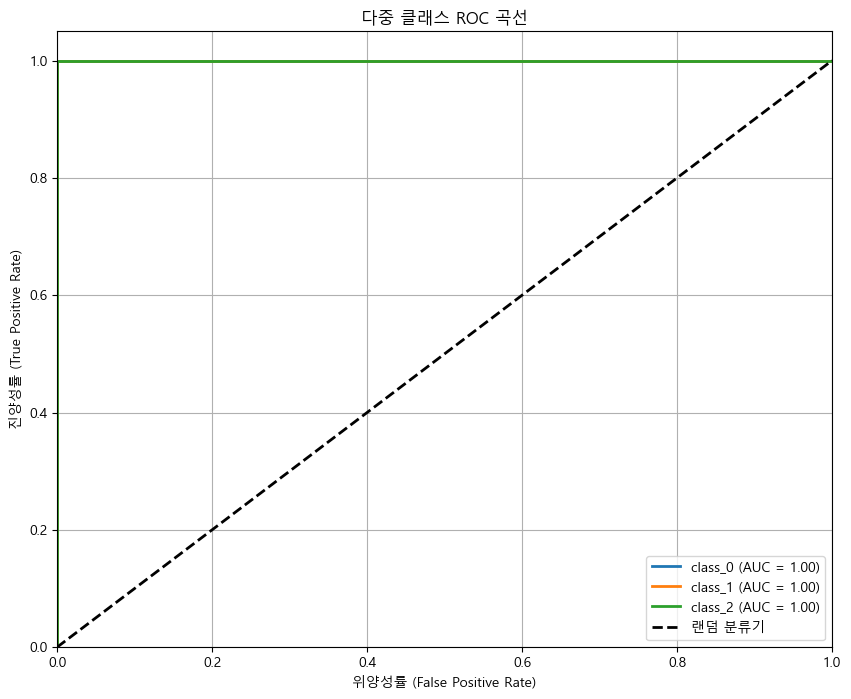

In [15]:
# 훈련 히스토리 시각화
plt.figure(figsize=(12, 4))

# 손실값 변화
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='훈련 손실값', marker='o')
plt.plot(history.history['val_loss'], label='검증 손실값', marker='s')
plt.title('모델 손실값 변화')
plt.xlabel('에포크')
plt.ylabel('손실값')
plt.legend()
plt.grid(True)

# 정확도 변화
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='훈련 정확도', marker='o')
plt.plot(history.history['val_accuracy'], label='검증 정확도', marker='s')
plt.title('모델 정확도 변화')
plt.xlabel('에포크')
plt.ylabel('정확도')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 특성 중요도 분석을 위한 시각화 (첫 번째 레이어 가중치)
first_layer_weights = model.layers[0].get_weights()[0]

plt.figure(figsize=(12, 8))
plt.imshow(first_layer_weights.T, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('첫 번째 은닉층 가중치 시각화')
plt.xlabel('입력 특성')
plt.ylabel('뉴런')
plt.show()

# 다중 클래스 ROC 곡선
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 원핫 인코딩된 실제값
y_test_binary = label_binarize(y_test, classes=[0, 1, 2])

plt.figure(figsize=(10, 8))

# 각 클래스별 ROC 곡선
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_binary[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{wine.target_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='랜덤 분류기')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('위양성률 (False Positive Rate)')
plt.ylabel('진양성률 (True Positive Rate)')
plt.title('다중 클래스 ROC 곡선')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## 8. 결론 및 요약

### 모델 성능 요약
- **모델 구조**: 4개의 은닉층(128→64→32→32)과 소프트맥스 출력층
- **데이터셋**: 와인 데이터 178개 샘플, 13개 화학적 특성
- **클래스**: 3개 와인 종류 (class_0, class_1, class_2)
- **데이터 분할**: 훈련 80%, 테스트 20% (층화 샘플링)
- **전처리**: StandardScaler를 사용한 표준화 + 원핫 인코딩

### 주요 개선사항
1. **다중 클래스 분류**: 소프트맥스 활성화 함수와 categorical_crossentropy 손실 함수 사용
2. **원핫 인코딩**: 다중 클래스 레이블을 원핫 벡터로 변환
3. **콜백 추가**: ModelCheckpoint와 EarlyStopping으로 과적합 방지
4. **확장된 시각화**: 
   - 클래스별 예측 확률 분포
   - 첫 번째 레이어 가중치 히트맵
   - 다중 클래스 ROC 곡선
5. **평가 메트릭 확장**: 각 클래스별 정밀도, 재현율, F1-점수 포함

### 모델의 특징
- **소규모 데이터셋**: 178개 샘플로 상대적으로 작은 데이터셋
- **균형잡힌 클래스**: 각 클래스가 비교적 균등하게 분포
- **고차원 특성**: 13개의 화학적 특성으로 와인 분류

### 파일 저장
- `와인분류_딥러닝.keras`: 최적 모델 가중치
- `와인분류_딥러닝.bin`: 훈련 히스토리

이 노트북은 다중 클래스 분류를 위한 딥러닝 파이프라인의 좋은 예시가 되며, 
소규모 데이터셋에서도 효과적인 분류 성능을 보여줍니다.
